# 125. Sentiment Analysis with an RNN

### Network Architecture

<img src="network_diagram.png" width=30%>

In [1]:
import torch
import numpy as np
from torchtext import data
from torchtext.data import TabularDataset
from torchtext.data import Iterator
import urllib.request as request
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 실습 data IMBD download

In [5]:
request.urlretrieve(
    'https://raw.github.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv',
    filename='./sample_data/IMBD_review.csv')

('./sample_data/IMBD_review.csv', <http.client.HTTPMessage at 0x7f5b4e682a90>)

In [6]:
pd.set_option('max_colwidth', 400)

df = pd.read_csv('sample_data/IMBD_review.csv')
df.head(2)

,review,sentiment
0,"My family and I normally do not watch local movies for the simple reason that they are poorly made, they lack the depth, and just not worth our time.<br /><br />The trailer of ""Nasaan ka man"" caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon. The movie exceeded our expectations. The cinematography was very good, the story beautiful and the ...",1
1,"Believe it or not, this was at one time the worst movie I had ever seen. Since that time, I have seen many more movies that are worse (how is it possible??) Therefore, to be fair, I had to give this movie a 2 out of 10. But it was a tough call.",0


In [7]:
df.shape

(50000, 2)

### Data Preprocessing
- 구두점과 줄바꿈 (\\n, ``<br />``)을 없앤다  

In [8]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
def preprocess(s):
    s = s.lower()
    s = s.replace('<br', '')
    s = s.replace('/>', '')
    s = s.replace('\n', '')
    s = ''.join(c for c in s if c not in punctuation)
    return s

df['review'] = df['review'].apply(preprocess)
df.head(2)

,review,sentiment
0,my family and i normally do not watch local movies for the simple reason that they are poorly made they lack the depth and just not worth our time the trailer of nasaan ka man caught my attention my daughter in laws and daughters so we took time out to watch it this afternoon the movie exceeded our expectations the cinematography was very good the story beautiful and the acting awesome jerich...,1
1,believe it or not this was at one time the worst movie i had ever seen since that time i have seen many more movies that are worse how is it possible therefore to be fair i had to give this movie a 2 out of 10 but it was a tough call,0


### sentence의 길이 시각화 및 MAX_LENGTH 지정

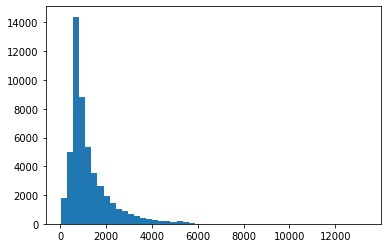

In [10]:
import matplotlib.pyplot as plt

plt.hist([len(x) for x in df['review'].values], bins=50)
None

In [11]:
MAX_LENGTH = 200

### Train / Test dataset 으로 분리하여 저장

In [12]:
DATA_SIZE = 25000

In [14]:
train_df = df[:DATA_SIZE]
test_df = df[-DATA_SIZE:]

train_df.to_csv('sample_data/train_data.csv', header=False, index=False)
test_df.to_csv('sample_data/test_data.csv', header=False, index=False)

### Field 정의

- torchtext.data.Field 함수 이용 
    - sequential: TEXT 는 순서가 있는 (sequential) 데이터이기 때문에 True, LABEL 데이터는 순서가 필요없기 때문에 False
    - use_vocab: 단어장(Vocab) 객체를 사용할지의 여부. 텍스트가 데이터있는 TEXT 만 True 로 정의
    - tokenize: 단어의 토크나이징을 맡아줄 함수. 한국어의 경우 보통 konlpy 의 토크나이징 함수들을 사용
    - lower: 소문자 전환 여부 입니다. 영어는 보통 True. 
    - batch_first: tensor 의 shape이 (B, 문장의 최대 길이) 로 만들어진다.
    - preprocessing: 전처리는 토큰화 후, 수치화하기 전 사이에서 작동
    
    
- TabularDataset 에 Field 적용
    - fields: 리스트 형태로 [('필드이름(임의지정)', Field object), ('필드이름(임의지정)', Field object)]


- 단어장 TEXT.vocab은 train_data 만으로 만든다.
    - use_vocab=True
    - TEXT.build_vocab(train_data)
    - <unk> : 0
    - <pad> : 1
    - TEXT.vocab.stoi : 단어 index
    - TEXT.vocab.itos : 단어 list

In [16]:
# set up fields
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  fix_length=MAX_LENGTH)
LABEL = data.Field(sequential=False,
                  use_vocab=False,
                  dtype=torch.float) #for BCEWithLogitsLoss 

train_data = TabularDataset(
                path='./sample_data/train_data.csv', 
                format='csv', 
                fields=[('text', TEXT), ('label', LABEL)])
test_data = TabularDataset(
                path='./sample_data/test_data.csv',
                format='csv',
                fields=[('text', TEXT), ('label', LABEL)]
                )

- vars 내장 함수를 이용하여 data 출력

In [17]:
print(vars(train_data[0]))

{'text': ['my', 'family', 'and', 'i', 'normally', 'do', 'not', 'watch', 'local', 'movies', 'for', 'the', 'simple', 'reason', 'that', 'they', 'are', 'poorly', 'made', 'they', 'lack', 'the', 'depth', 'and', 'just', 'not', 'worth', 'our', 'time', 'the', 'trailer', 'of', 'nasaan', 'ka', 'man', 'caught', 'my', 'attention', 'my', 'daughter', 'in', 'laws', 'and', 'daughters', 'so', 'we', 'took', 'time', 'out', 'to', 'watch', 'it', 'this', 'afternoon', 'the', 'movie', 'exceeded', 'our', 'expectations', 'the', 'cinematography', 'was', 'very', 'good', 'the', 'story', 'beautiful', 'and', 'the', 'acting', 'awesome', 'jericho', 'rosales', 'was', 'really', 'very', 'good', 'sos', 'claudine', 'barretto', 'the', 'fact', 'that', 'i', 'despised', 'diether', 'ocampo', 'proves', 'he', 'was', 'effective', 'at', 'his', 'role', 'i', 'have', 'never', 'been', 'this', 'touched', 'moved', 'and', 'affected', 'by', 'a', 'local', 'movie', 'before', 'imagine', 'a', 'cynic', 'like', 'me', 'dabbing', 'my', 'eyes', 'at'

### 단어장 생성

In [18]:
TEXT.build_vocab(train_data, max_size=50000)

In [19]:
list(TEXT.vocab.stoi.items())[:5]

[('<unk>', 0), ('<pad>', 1), ('the', 2), ('and', 3), ('a', 4)]

In [20]:
TEXT.vocab.itos[:5]

['<unk>', '<pad>', 'the', 'and', 'a']

## Data Loader 생성
- padding은 자동으로 해준다

In [21]:
BATCH_SIZE = 30

train_loader = Iterator(train_data,
                       batch_size=BATCH_SIZE,
                       device=device)
test_loader = Iterator(test_data,
                      batch_size=BATCH_SIZE,
                      device=device)

---
# Build the Model
- 다음의 layer로 구성

    1. 임베딩 레이어
    2. LSTM 레이어
    3. LSTM 계층 출력을 원하는 output_size에 매핑하는 fully-connected output layer
    4. 모든 출력을 0-1 값으로 바꾸는 sigmoid activation layer

In [22]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, drop_out=0.3):
        super(SentimentRNN, self).__init__()
        
        # embedding and LSTM layers
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_out)
        
        self.fc = nn.Linear(hidden_dim*n_layers, output_dim)

        self.drop = nn.Dropout(drop_out)   

    def forward(self, x):
        #x:[200,3](seq,batch)
        x = self.drop(self.embed(x))
        
        #out:[200, 3, 256](seq, batch, hidden)
        #h,c:[2, 3, 256](layer, batch, hidden)
        out, (h, c) = self.lstm(x) 
        
        #h:[3, 512](batch, hidden*layer)
        h = self.drop(torch.cat((h[-2,:,:], h[-1,:,:]), dim=1))
        #out:[3, 1](batch,outdim)
        out = self.fc(h.squeeze(0))
        return out

## Instantiate the network

In [23]:
vocab_size = len(TEXT.vocab)
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)

print(model)

SentimentRNN(
  (embed): Embedding(50002, 400)
  (lstm): LSTM(400, 256, num_layers=2, dropout=0.3)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)


## Training

- BCEWithLogitsLoss : Sigmoid + BCELoss

In [24]:
# loss and optimization functions
lr=0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [25]:
for batch in train_loader:
    print(batch.label.dtype)
    break

torch.float32


In [26]:
# training params

epochs = 5 

# train for some number of epochs
for epoch in range(epochs):
    
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in train_loader:
        
        optimizer.zero_grad()
        z = model(batch.text).squeeze(1)

        loss = criterion(z, batch.label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        correct = (torch.round(torch.sigmoid(z)) == batch.label).float().mean()
        train_acc += correct
    
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for batch in test_loader:
            z = model(batch.text).squeeze(1)

            loss = criterion(z, batch.label)
        
            val_loss += loss
            correct = (torch.round(torch.sigmoid(z)) == batch.label).float().mean()
            val_acc += correct
        
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "Train Loss: {:.6f}...".format(train_loss/len(train_loader)),
          "Train Acc: {:.6f}...".format(train_acc/len(train_loader)),
          "Val Loss: {:.4f}".format(val_loss/len(test_loader)),
          "Val Acc: {:.4f}".format(val_acc/len(test_loader)))

Epoch: 1/5... Train Loss: 0.692892... Train Acc: 0.520064... Val Loss: 0.6822 Val Acc: 0.5572
Epoch: 2/5... Train Loss: 0.672706... Train Acc: 0.569465... Val Loss: 0.5782 Val Acc: 0.7327
Epoch: 3/5... Train Loss: 0.506230... Train Acc: 0.758472... Val Loss: 0.4233 Val Acc: 0.8130
Epoch: 4/5... Train Loss: 0.342711... Train Acc: 0.855714... Val Loss: 0.3787 Val Acc: 0.8446
Epoch: 5/5... Train Loss: 0.251304... Train Acc: 0.900879... Val Loss: 0.3669 Val Acc: 0.8600


---
## Testing

### Inference on a test review

In [38]:
# negative test review
test_review = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
# positive test review
test_review = 'This movie had the best acting and the dialogue was so good. I loved it.'

In [39]:
# get rid of punctuation
reviews = test_review.lower() # lowercase, standardize
reviews = ''.join([c for c in reviews if c not in punctuation])

# split by new lines and spaces
tokenized = reviews.split()
tokenized[:5]

['this', 'movie', 'had', 'the', 'best']

In [40]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]
indexed[:5]

[11, 17, 68, 2, 115]

In [41]:
input = torch.tensor(indexed + [1] * (200-len(indexed))).unsqueeze(1).to(device)
input.shape

torch.Size([200, 1])

In [42]:
torch.sigmoid(model(input))

tensor([0.9789], device='cuda:0', grad_fn=<SigmoidBackward>)